In [1]:
import s3fs
import datetime
import xarray as xr
import numpy as np

import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors

from cartopy import crs as ccrs
import cartopy.feature as cfeature

In [2]:
fs = s3fs.S3FileSystem(anon=True)

GOES products
* [documentation](https://github.com/awslabs/open-data-docs/tree/main/docs/noaa/noaa-goes16#about-the-data)

In [3]:
products = fs.ls('noaa-goes16')

Select a certain date

In [4]:
year = 2023
month = 3
day = 31
hour = 22

julian_day = datetime.datetime(year, month, day).strftime('%j')
print(julian_day)

090


Find the data files for the datetime selected

In [5]:
bucket = 'noaa-goes16'
product = 'ABI-L1b-RadC'

data_path = bucket + '/' + product + '/'  + str(year) + '/' + julian_day + '/' + str(hour).zfill(2)

files = fs.ls(data_path)

#for file in files:
#    print(file.split('/')[-1])

Choose a specific shapshot within the hour
* bands are listed [here](https://www.goes-r.gov/mission/ABI-bands-quick-info.html)

In [6]:
observation_start = '2215'
observation_end = '2245'
product_name = 'ABI-L1b-RadC-M6C01' #blue vis band

matches = [file for file in files if (file.split('/')[-1].split('_')[3][8:12] >= observation_start and file.split('/')[-1].split('_')[3][8:12] <= observation_end and file.split('/')[-1].split('_')[1] == product_name)]

for match in matches:
    print(match.split('/')[-1])
    print('Approximate file size (MB):', round((fs.size(match)/1.0E6), 2))

OR_ABI-L1b-RadC-M6C01_G16_s20230902216168_e20230902218545_c20230902219033.nc
Approximate file size (MB): 12.38
OR_ABI-L1b-RadC-M6C01_G16_s20230902221168_e20230902223547_c20230902224025.nc
Approximate file size (MB): 12.14
OR_ABI-L1b-RadC-M6C01_G16_s20230902226168_e20230902228547_c20230902228595.nc
Approximate file size (MB): 11.88
OR_ABI-L1b-RadC-M6C01_G16_s20230902231168_e20230902233543_c20230902234006.nc
Approximate file size (MB): 11.63
OR_ABI-L1b-RadC-M6C01_G16_s20230902236168_e20230902238543_c20230902239007.nc
Approximate file size (MB): 11.33
OR_ABI-L1b-RadC-M6C01_G16_s20230902241168_e20230902243545_c20230902244012.nc
Approximate file size (MB): 11.02


Open the selected file

In [7]:
remote_file = fs.open(matches[1], mode='rb')
ds = xr.open_dataset(remote_file, engine='h5netcdf')

Function to get latitude and longitude from goes fixed grid

In [8]:
def calculate_abi_lat_lon(ds):
    
    # Read in GOES ABI fixed grid projection variables and constants
    x_coordinate_1d = ds.x  # E/W scanning angle in radians
    y_coordinate_1d = ds.y  # N/S elevation angle in radians
    projection_info = ds.goes_imager_projection  # ABI fixed grid contstants
    lon_origin = projection_info.longitude_of_projection_origin
    H = projection_info.perspective_point_height+projection_info.semi_major_axis
    r_eq = projection_info.semi_major_axis
    r_pol = projection_info.semi_minor_axis
    
    # Create 2D coordinate matrices from 1D coordinate vectors
    x_coordinate_2d, y_coordinate_2d = np.meshgrid(x_coordinate_1d, y_coordinate_1d)
    
    # Equations to calculate latitude and longitude
    lambda_0 = (lon_origin*np.pi)/180.0  
    a_var = np.power(np.sin(x_coordinate_2d),2.0) + (np.power(np.cos(x_coordinate_2d),2.0)*(np.power(np.cos(y_coordinate_2d),2.0)+(((r_eq*r_eq)/(r_pol*r_pol))*np.power(np.sin(y_coordinate_2d),2.0))))
    b_var = -2.0*H*np.cos(x_coordinate_2d)*np.cos(y_coordinate_2d)
    c_var = (H**2.0)-(r_eq**2.0)
    r_s = (-1.0*b_var - np.sqrt((b_var**2)-(4.0*a_var*c_var)))/(2.0*a_var)
    s_x = r_s*np.cos(x_coordinate_2d)*np.cos(y_coordinate_2d)
    s_y = - r_s*np.sin(x_coordinate_2d)
    s_z = r_s*np.cos(x_coordinate_2d)*np.sin(y_coordinate_2d)
    
    lat = (180.0/np.pi)*(np.arctan(((r_eq*r_eq)/(r_pol*r_pol))*((s_z/np.sqrt(((H-s_x)*(H-s_x))+(s_y*s_y))))))
    lon = (lambda_0 - np.arctan(s_y/(H-s_x)))*(180.0/np.pi)
    
    return lat, lon

Get the geostationary projection variables

In [9]:
projection_variables = ds.goes_imager_projection
satellite_height = projection_variables.perspective_point_height
semi_major_axis = projection_variables.semi_major_axis
semi_minor_axis = projection_variables.semi_minor_axis
central_longitude = projection_variables.longitude_of_projection_origin

globe = ccrs.Globe(semimajor_axis=semi_major_axis, semiminor_axis=semi_minor_axis)
geo_projection = ccrs.Geostationary(central_longitude=central_longitude, satellite_height=satellite_height,
                                    globe=globe, sweep_axis='x')

Close the opened file

In [10]:
remote_file.close()
ds.close()

Reopen and plot each selected file
* this can be made into a loop using Amy Huff's source code

/tmp/ipykernel_29849/2546833336.py:20: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-1.0*b_var - np.sqrt((b_var**2)-(4.0*a_var*c_var)))/(2.0*a_var)


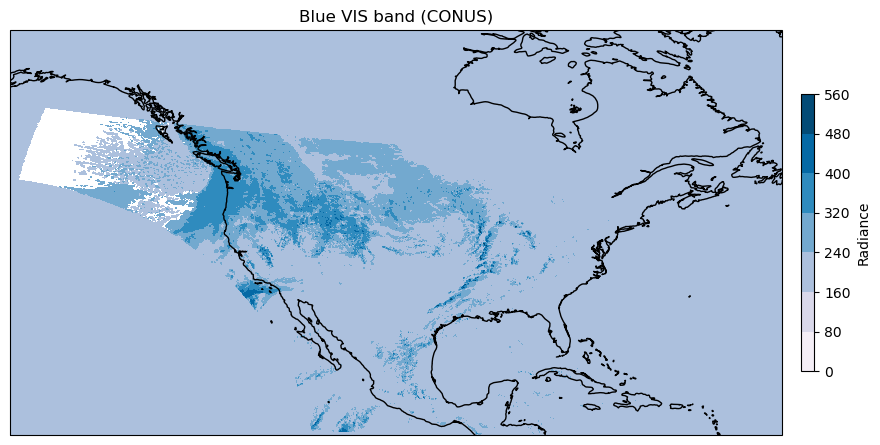

In [11]:
with fs.open(matches[2], mode='rb') as remote_file:
    with xr.open_dataset(remote_file, engine='h5netcdf') as ds:
        projection=ccrs.PlateCarree()
        fig,ax=plt.subplots(1, figsize=(12,12),subplot_kw={'projection': projection})
        cmap = plt.cm.PuBu
        #levels = np.linspace(0, 6, 11)
        
        lat, lon = calculate_abi_lat_lon(ds)
        ax.set_extent([np.nanmin(lon), np.nanmax(lon), np.nanmin(lat), np.nanmax(lat)])

        c=ax.contourf(lon, lat, ds.Rad, cmap=cmap, extend='neither')#, levels=levels)
        clb=plt.colorbar(c, shrink=0.3, pad=0.02, ax=ax)
        ax.set_title('Blue VIS band (CONUS)')
        clb.set_label('Radiance')

        ax.coastlines(resolution='50m', color='black', linewidth=1)

Trying with the mesoscale sector

In [ ]:
bucket = 'noaa-goes16'
product = 'ABI-L1b-RadM'

data_path = bucket + '/' + product + '/'  + str(year) + '/' + julian_day + '/' + str(hour).zfill(2)

files = fs.ls(data_path)

# for file in files:
#    print(file.split('/')[-1])

In [ ]:
observation_start = '2215'
observation_end = '2245'
product_name = 'ABI-L1b-RadM1-M6C01' #blue vis band

matches = [file for file in files if (file.split('/')[-1].split('_')[3][8:12] >= observation_start and file.split('/')[-1].split('_')[3][8:12] <= observation_end and file.split('/')[-1].split('_')[1] == product_name)]

for match in matches:
    print(match.split('/')[-1])
    print('Approximate file size (MB):', round((fs.size(match)/1.0E6), 2))

In [ ]:
with fs.open(matches[1], mode='rb') as remote_file:
    with xr.open_dataset(remote_file, engine='h5netcdf') as ds:
        projection=ccrs.PlateCarree()
        fig,ax=plt.subplots(1, figsize=(12,12),subplot_kw={'projection': projection})
        cmap = plt.cm.PuBu
        #levels = np.linspace(0, 6, 11)
        
        lat, lon = calculate_abi_lat_lon(ds)
        ax.set_extent([np.nanmin(lon), np.nanmax(lon), np.nanmin(lat), np.nanmax(lat)])
        #ax.set_extent([-67, -125, 25, 49]) --- CONUS

        c=ax.contourf(lon, lat, ds.Rad, cmap=cmap, extend='neither')#, levels=levels)
        clb=plt.colorbar(c, shrink=0.3, pad=0.02, ax=ax)
        ax.set_title('Blue VIS band (Mesoscale)')
        clb.set_label('Radiance')

        ax.coastlines(resolution='50m', color='black', linewidth=1)
        ax.add_feature(cfeature.STATES)

Trying to create true color RGB

In [ ]:
bucket = 'noaa-goes16'
product = 'ABI-L1b-RadM'

data_path = bucket + '/' + product + '/'  + str(year) + '/' + julian_day + '/' + str(hour).zfill(2)

files = fs.ls(data_path)

# for file in files:
#     print(file.split('/')[-1])

In [ ]:
observation_start = '2215'
observation_end = '2216'
blue_name = 'ABI-L1b-RadM1-M6C01' #blue vis band
red_name = 'ABI-L1b-RadM1-M6C02' #red vis band
veggie_name = 'ABI-L1b-RadM1-M6C03' #veggie near-ir band

blue_matches = [file for file in files if (file.split('/')[-1].split('_')[3][8:12] >= observation_start and file.split('/')[-1].split('_')[3][8:12] <= observation_end and file.split('/')[-1].split('_')[1] == blue_name)]
red_matches = [file for file in files if (file.split('/')[-1].split('_')[3][8:12] >= observation_start and file.split('/')[-1].split('_')[3][8:12] <= observation_end and file.split('/')[-1].split('_')[1] == red_name)]
veggie_matches = [file for file in files if (file.split('/')[-1].split('_')[3][8:12] >= observation_start and file.split('/')[-1].split('_')[3][8:12] <= observation_end and file.split('/')[-1].split('_')[1] == veggie_name)]


print('blue matches:')
for match in blue_matches:
    print(match.split('/')[-1])
    print('Approximate file size (MB):', round((fs.size(match)/1.0E6), 2))

print('red matches:')
for match in red_matches:
    print(match.split('/')[-1])
    print('Approximate file size (MB):', round((fs.size(match)/1.0E6), 2))
    
print('veggie matches:')
for match in veggie_matches:
    print(match.split('/')[-1])
    print('Approximate file size (MB):', round((fs.size(match)/1.0E6), 2))

In [ ]:
blue_remote_file = fs.open(blue_matches[0], mode='rb')
ch1_ds = xr.open_dataset(blue_remote_file, engine='h5netcdf')

red_remote_file = fs.open(red_matches[0], mode='rb')
ch2_ds = xr.open_dataset(red_remote_file, engine='h5netcdf')

green_remote_file = fs.open(veggie_matches[0], mode='rb')
ch3_ds = xr.open_dataset(green_remote_file, engine='h5netcdf')